**GROUP 12:** <br>
- Pedro Cerejeira (20230442) <br>

<hr>
<a class="anchor" id="import">
    
# 0. Next Steps
    
</a>

# For now, not considering medication, primary_diagnosis, secondary_diagnosis and additional_diagnosis since they are not numeric.

**I should try to find an alternative to use them. Encoding or creating some new numeric Features from these columns**

In [484]:
# Also dropping medication, primary_diagnosis, secondary_diagnosis and additional_diagnosis since they are not numeric
#init_train_copy.drop(columns=(['medication', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis']), inplace=True)
#init_test_copy.drop(columns=(['medication', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis']), inplace=True)

<hr>
<a class="anchor" id="import">
    
# 1. Import
    
</a>

<a class="anchor" id="importlibraries">

## 1.1. Import Libraries

</a>

In [791]:
# Import Packages
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Seeting seaborn style
sns.set()

# Setting display options to show all columns
pd.set_option('display.max_columns', None)

<a class="anchor" id="importdatasets">

## 1.1. Import Datasets

</a>

In [792]:
init_train = pd.read_csv("train.csv")
init_test = pd.read_csv("test.csv")

# SPLIT HERE

<hr>
<a class="anchor" id="import">
    
# 1. Dataset Exploration
    
</a>

In [823]:
df = init_train.copy()
df_test = init_test.copy()

In [695]:
df["discharge_disposition"].value_counts()

Discharged to home                                                                                           42256
Discharged/transferred to SNF                                                                                 9780
Discharged/transferred to home with home health service                                                       9005
Discharged/transferred to another short term hospital                                                         1488
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1393
Expired                                                                                                       1135
Discharged/transferred to another type of inpatient care institution                                           822
Not Mapped                                                                                                     679
Discharged/transferred to ICF                                                   

In [824]:
excluded_dispositions = [
    'Hospice / home', 
    'Expired', 
    'Hospice / medical facility', 
    'Expired at home. Medicaid only, hospice.', 
    'Expired in a medical facility. Medicaid only, hospice.'
]

filter_condition = ~df['discharge_disposition'].isin(excluded_dispositions)
print(len(df))
df = df[filter_condition]
print(len(df))

filter_condition2 = ~df_test['discharge_disposition'].isin(excluded_dispositions)
df_test = df_test[filter_condition2]

71236
69575


In [795]:
df["discharge_disposition"].value_counts()

Discharged to home                                                                                           42256
Discharged/transferred to SNF                                                                                 9780
Discharged/transferred to home with home health service                                                       9005
Discharged/transferred to another short term hospital                                                         1488
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1393
Discharged/transferred to another type of inpatient care institution                                           822
Not Mapped                                                                                                     679
Discharged/transferred to ICF                                                                                  571
Left AMA                                                                        

In [825]:
df['OUTPUT_LABEL'] = (df.readmitted_binary == 'Yes').astype('int')

In [849]:
df["OUTPUT_LABEL"]

0        0
1        0
2        0
3        0
4        0
        ..
71231    0
71232    0
71233    1
71234    0
71235    0
Name: OUTPUT_LABEL, Length: 69575, dtype: int32

In [826]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

print('Prevalence:%.3f'%calc_prevalence(df['OUTPUT_LABEL'].values))

Prevalence:0.114


In [827]:
print('Number of columns:',len(df.columns))

Number of columns: 32


<hr>
<a class="anchor" id="import">
    
# 2. Feature Engineering
    
</a>

In [829]:
# replace ? with nan
df = df.replace('?',np.nan)

df_test = df_test.replace('?',np.nan)

<hr>
<a class="anchor" id="import">
    
# 3. Numerical Features
    
</a>

In [830]:
cols_num = ['length_of_stay_in_hospital','non_lab_procedures', 'number_lab_tests', 'number_of_medications',
       'outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year','number_diagnoses']

cols_num_test = ['length_of_stay_in_hospital','non_lab_procedures', 'number_lab_tests', 'number_of_medications',
       'outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year','number_diagnoses']

In [831]:
df.columns

Index(['encounter_id', 'country', 'patient_id', 'race', 'gender', 'age',
       'weight', 'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass',
       'OUTPUT_LABEL'],
      dtype='object')

In [704]:
df[cols_num].isnull().sum()

length_of_stay_in_hospital            0
non_lab_procedures                    0
number_lab_tests                      0
number_of_medications                 0
outpatient_visits_in_previous_year    0
emergency_visits_in_previous_year     0
inpatient_visits_in_previous_year     0
number_diagnoses                      0
dtype: int64

<hr>
<a class="anchor" id="import">
    
# 4. Categorical Features
    
</a>

In [832]:
cols_cat = ['race', 'gender', 
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds', 'payer_code']

In [642]:
df.columns

Index(['encounter_id', 'country', 'patient_id', 'race', 'gender', 'age',
       'weight', 'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass',
       'OUTPUT_LABEL'],
      dtype='object')

In [833]:
df[cols_cat].isnull().sum()

race                                      4968
gender                                       0
glucose_test_result                      66008
a1c_test_result                          57792
change_in_meds_during_hospitalization        0
prescribed_diabetes_meds                     0
payer_code                               27623
dtype: int64

In [834]:
df['race'] = df['race'].fillna('UNK')
df['payer_code'] = df['payer_code'].fillna('UNK')
df['glucose_test_result'] = df['glucose_test_result'].fillna('UNK')
df['a1c_test_result'] = df['a1c_test_result'].fillna('UNK')
df['medical_specialty'] = df['medical_specialty'].fillna('UNK')

df_test['race'] = df_test['race'].fillna('UNK')
df_test['payer_code'] = df_test['payer_code'].fillna('UNK')
df_test['glucose_test_result'] = df_test['glucose_test_result'].fillna('UNK')
df_test['a1c_test_result'] = df_test['a1c_test_result'].fillna('UNK')
df_test['medical_specialty'] = df_test['medical_specialty'].fillna('UNK')

In [802]:
print('Number medical specialty:', df.medical_specialty.nunique())
df.groupby('medical_specialty').size().sort_values(ascending = False)[0:10]

Number medical specialty: 69


medical_specialty
UNK                           33996
InternalMedicine              10027
Emergency/Trauma               5218
Family/GeneralPractice         5092
Cardiology                     3664
Surgery-General                2117
Nephrology                     1082
Orthopedics                     947
Orthopedics-Reconstructive      866
Radiologist                     805
dtype: int64

In [803]:
print('Number medical specialty:', df_test.medical_specialty.nunique())
df_test.groupby('medical_specialty').size().sort_values(ascending = False)[0:10]

Number medical specialty: 65


medical_specialty
UNK                           14620
InternalMedicine               4210
Emergency/Trauma               2201
Family/GeneralPractice         2160
Cardiology                     1615
Surgery-General                 942
Nephrology                      457
Orthopedics                     445
Orthopedics-Reconstructive      364
Radiologist                     316
dtype: int64

In [835]:
top_10 = ['InternalMedicine','Emergency/Trauma','Family/GeneralPractice',\
          'Cardiology', 'Surgery-General','Nephrology',\
          'Orthopedics','Orthopedics-Reconstructive',\
          'Radiologist','UNK']

# make a new column with duplicated data
df['med_spec'] = df['medical_specialty'].copy()
df_test['med_spec'] = df_test['medical_specialty'].copy()


# replace all specialties not in top 10 with 'Other' category
df.loc[~df.med_spec.isin(top_10),'med_spec'] = 'Other'

df_test.loc[~df_test.med_spec.isin(top_10),'med_spec'] = 'Other'

In [805]:
df.groupby('med_spec').size()

med_spec
Cardiology                     3664
Emergency/Trauma               5218
Family/GeneralPractice         5092
InternalMedicine              10027
Nephrology                     1082
Orthopedics                     947
Orthopedics-Reconstructive      866
Other                          5761
Radiologist                     805
Surgery-General                2117
UNK                           33996
dtype: int64

To convert our categorical features to numbers, we will use a technique called one-hot encoding. In one-hot encoding, you create a new column for each unique value in that column. Then the value of the column is 1 if the sample has that unique value or 0 otherwise. For example, for the column race, we would create new columns ('race_Caucasian','race_AfricanAmerican', etc). If the patient's race is Caucasian, the patient gets a 1 under 'race_Caucasian' and 0 under the rest of the race columns. To create these one-hot encoding columns, we can use the get_dummies function.

In [836]:
cols_cat_num = ['admission_type', 'discharge_disposition', 'admission_source']

df[cols_cat_num]

admission_type                              discharge_disposition  \
0          Emergency                                 Discharged to home   
1          Emergency  Discharged/transferred to a federal health car...   
2                NaN                                 Discharged to home   
3          Emergency                                 Discharged to home   
4           Elective  Discharged/transferred to home with home healt...   
...              ...                                                ...   
71231       Elective                                 Discharged to home   
71232         Urgent                                                NaN   
71233            NaN                                         Not Mapped   
71234      Emergency                      Discharged/transferred to SNF   
71235         Urgent                                 Discharged to home   

                                  admission_source  
0                                   Emergency Room  
1                                  Clinic Referral  
2                                              NaN  
3       Transfer from another health care facility  
4                               Physician Referral  
...                                            ...  
71231                           Physician Referral  
71232                           Physician Referral  
71233                                          NaN  
71234                               Emergency Room  
71235                               Emergency Room  

[69575 rows x 3 columns]

In [838]:
df.columns

Index(['encounter_id', 'country', 'patient_id', 'race', 'gender', 'age',
       'weight', 'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass',
       'OUTPUT_LABEL', 'med_spec'],
      dtype='object')

In [839]:
df_cat = pd.get_dummies(df[cols_cat + cols_cat_num + ['medical_specialty']],drop_first = True)

df_cat_test = pd.get_dummies(df_test[cols_cat + cols_cat_num + ['medical_specialty']],drop_first = True)

In [712]:
df_cat.head()

race_Asian  race_Caucasian  race_Hispanic  race_Other  race_UNK  \
0           0               1              0           0         0   
1           0               0              0           0         0   
2           0               1              0           0         0   
3           0               0              0           0         0   
4           0               1              0           0         0   

   gender_Male  gender_Unknown/Invalid  glucose_test_result_>300  \
0            0                       0                         0   
1            1                       0                         0   
2            0                       0                         0   
3            1                       0                         0   
4            0                       0                         0   

   glucose_test_result_Norm  glucose_test_result_UNK  a1c_test_result_>8  \
0                         0                        1                   0   
1                         0                        1                   0   
2                         0                        1                   0   
3                         0                        1                   0   
4                         0                        1                   0   

   a1c_test_result_Norm  a1c_test_result_UNK  \
0                     0                    1   
1                     0                    1   
2                     0                    1   
3                     0                    1   
4                     0                    1   

   change_in_meds_during_hospitalization_No  prescribed_diabetes_meds_Yes  \
0                                         1                             0   
1                                         1                             1   
2                                         0                             1   
3                                         1                             0   
4                                         1                             0   

   payer_code_CH  payer_code_CM  payer_code_CP  payer_code_DM  payer_code_FR  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   payer_code_HM  payer_code_MC  payer_code_MD  payer_code_MP  payer_code_OG  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              1              0              0              0   
4              1              0              0              0              0   

   payer_code_OT  payer_code_PO  payer_code_SI  payer_code_SP  payer_code_UN  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   payer_code_UNK  payer_code_WC  admission_type_Emergency  \
0               1              0                         1   
1               1              0                         1   
2               1              0                         0   
3               0              0                         1   
4               0              0                         0   

   admission_type_Newborn  admission_type_Not Available  \
0                       0                             0   
1                       0     

In [765]:
df_cat_test.head()

race_Asian  race_Caucasian  race_Hispanic  race_Other  race_UNK  \
0           0               1              0           0         0   
1           0               1              0           0         0   
2           0               0              0           0         0   
3           0               1              0           0         0   
4           0               1              0           0         0   

   gender_Male  glucose_test_result_>300  glucose_test_result_Norm  \
0            1                         0                         0   
1            1                         1                         0   
2            1                         0                         0   
3            1                         0                         0   
4            1                         0                         0   

   glucose_test_result_UNK  a1c_test_result_>8  a1c_test_result_Norm  \
0                        1                   0                     0   
1                        0                   0                     0   
2                        1                   0                     0   
3                        1                   0                     0   
4                        1                   0                     0   

   a1c_test_result_UNK  change_in_meds_during_hospitalization_No  \
0                    1                                         1   
1                    1                                         1   
2                    1                                         1   
3                    1                                         0   
4                    1                                         1   

   prescribed_diabetes_meds_Yes  payer_code_CH  payer_code_CM  payer_code_CP  \
0                             1              0              0              0   
1                             0              0              0              0   
2                             1              0              0              0   
3                             1              0              0              0   
4                             1              0              0              0   

   payer_code_DM  payer_code_HM  payer_code_MC  payer_code_MD  payer_code_MP  \
0              0              1              0              0              0   
1              0              1              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   payer_code_OG  payer_code_OT  payer_code_PO  payer_code_SI  payer_code_SP  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   payer_code_UN  payer_code_UNK  payer_code_WC  admission_type_Emergency  \
0              0               0              0                         1   
1              0               0              0                         1   
2              0               1              0                         1   
3              0               0              0                         0   
4              0               1              0                         1   

   admission_type_Newborn  admission_type_Not Available  \
0                       0                             0   
1                       0                             0   
2                       0                             0   
3                       0                             1   
4                       0                             0   

   admission_type_Not Mapped  admission_type_Trauma Center

In [840]:
df = pd.concat([df,df_cat], axis = 1)

df_test = pd.concat([df_test,df_cat_test], axis = 1)

In [841]:
cols_all_cat = list(df_cat.columns)
cols_all_cat_test = list(df_cat_test.columns)

<hr>
<a class="anchor" id="import">
    
# 5. Extra Features
    
</a>

In [715]:
df[['age', 'weight']].head()

age weight
0  [70-80)    NaN
1  [50-60)    NaN
2  [60-70)    NaN
3  [60-70)    NaN
4  [70-80)    NaN

In [716]:
df.groupby('age').size()

age
[0-10)        104
[10-20)       473
[20-30)      1067
[30-40)      2529
[40-50)      6373
[50-60)     11296
[60-70)     14633
[70-80)     16873
[80-90)     11011
[90-100)     1739
dtype: int64

In [842]:
# Let's map these to 0-9 for the numerical data.

# remember age has nans
df['age'] = df['age'].fillna('UNK')

df_test['age'] = df_test['age'].fillna('UNK')



mode_age = df['age'].mode()[0]
df['age'] = df['age'].replace('UNK', mode_age)

mode_age = df_test['age'].mode()[0]
df_test['age'] = df_test['age'].replace('UNK', mode_age)

age_id = {'[0-10)':0, 
          '[10-20)':10, 
          '[20-30)':20, 
          '[30-40)':30, 
          '[40-50)':40, 
          '[50-60)':50,
          '[60-70)':60, 
          '[70-80)':70, 
          '[80-90)':80, 
          '[90-100)':90}
df['age_group'] = df.age.replace(age_id)

df_test['age_group'] = df_test.age.replace(age_id)

In [843]:
# Now let's look at weight. Recall that this feature is not filled out very often.
df.weight.notnull().sum()

2197

In [844]:
# Instead of creating an ordinal feature that we did above, let's just create a variable to say if weight was filled out or not. The presence of a variable might be predictive regardless of the value.
df['has_weight'] = df.weight.notnull().astype('int')

df_test['has_weight'] = df_test.weight.notnull().astype('int')

In [845]:
cols_extra = ['age_group','has_weight']
cols_extra_test = ['age_group','has_weight']

<hr>
<a class="anchor" id="import">
    
# 6. Engineering Features Summary
    
</a>

In [847]:
print('Total number of features:', len(cols_num + cols_all_cat + cols_extra))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))
print('Extra features:',len(cols_extra))

Total number of features: 150
Numerical Features: 8
Categorical Features: 140
Extra features: 2


In [848]:
df[cols_num + cols_all_cat + cols_extra].isnull().sum().sort_values(ascending = False).head(10)

length_of_stay_in_hospital                                0
medical_specialty_Hospitalist                             0
medical_specialty_InternalMedicine                        0
medical_specialty_Nephrology                              0
medical_specialty_Neurology                               0
medical_specialty_Neurophysiology                         0
medical_specialty_Obsterics&Gynecology-GynecologicOnco    0
medical_specialty_Obstetrics                              0
medical_specialty_ObstetricsandGynecology                 0
medical_specialty_Oncology                                0
dtype: int64

In [851]:
col2use = cols_num + cols_all_cat + cols_extra
df_data = df[col2use + ['OUTPUT_LABEL']]

col2use_test = cols_num_test + cols_all_cat_test + cols_extra_test
df_data_test = df_test[col2use_test]

<hr>
<a class="anchor" id="import">
    
# 7. Building Training/Validation/Test Samples
    
</a>

In [862]:
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

In [863]:
# Save 30% of the data as validation and test data 
df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


In [864]:
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

In [865]:
# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)

In [866]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.OUTPUT_LABEL.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.OUTPUT_LABEL.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.OUTPUT_LABEL.values)))

Test prevalence(n = 10436):0.114
Valid prevalence(n = 10436):0.117
Train all prevalence(n = 48703):0.113


In [868]:
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 69575)


In [869]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 11008):0.500


In [870]:
df_train_all.to_csv('df_train_all.csv',index=False)
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

In [871]:
X_train = df_train[col2use].values
X_train_all = df_train_all[col2use].values
X_valid = df_valid[col2use].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (48703, 150)
Training shapes: (11008, 150) (11008,)
Validation shapes: (10436, 150) (10436,)


In [872]:
scaler = StandardScaler()
scaler.fit(X_train_all)

StandardScaler()

In [873]:
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [874]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

In [875]:
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

In [876]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

In [877]:
thresh = 0.5

<hr>
<a class="anchor" id="import">
    
# 8. Model Selection
    
</a>

<a class="anchor" id="CatVarDist">

## 8.1. K nearest neighbors (KNN)

</a>

In [879]:
# k-nearest neighbors

knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(n_neighbors=100)

In [880]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.652
accuracy:0.612
recall:0.493
precision:0.647
specificity:0.691
prevalence:0.500
 
Validation:
AUC:0.615
accuracy:0.671
recall:0.473
precision:0.172
specificity:0.657
prevalence:0.117
 


In [881]:
knn_predict = knn.predict(X_valid_tf)

# Compute the confusion matrix
cm_gb = confusion_matrix(y_valid, knn_predict)
print(cm_gb)

[[6427 2784]
 [ 646  579]]


**Seems great, try to do for test and get file for efficiency**

<a class="anchor" id="CatVarDist">

## 8.2. Random Forest

</a>

In [749]:
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [750]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.694
accuracy:0.637
recall:0.622
precision:0.642
specificity:0.653
prevalence:0.500
 
Validation:
AUC:0.656
accuracy:0.616
recall:0.609
precision:0.174
specificity:0.617
prevalence:0.117
 


In [751]:
rf_predict = rf.predict(X_valid)

# Compute the confusion matrix
cm_gb = confusion_matrix(y_valid, rf_predict)
print(cm_gb)

[[ 876 8335]
 [  74 1151]]


In [752]:
rf_predict

array([1, 1, 1, ..., 1, 1, 0])

# SPLIT HERE

In [487]:
init_train.head()

encounter_id country  patient_id             race  gender      age weight  \
0        533253     USA       70110        Caucasian  Female  [70-80)      ?   
1        426224     USA    29775006  AfricanAmerican    Male  [50-60)      ?   
2        634063     USA    80729253        Caucasian  Female  [60-70)      ?   
3        890610     USA     2919042  AfricanAmerican    Male  [60-70)      ?   
4        654194     USA    84871971        Caucasian  Female  [70-80)      ?   

  payer_code  outpatient_visits_in_previous_year  \
0          ?                                   0   
1          ?                                   0   
2          ?                                   0   
3         MC                                   0   
4         HM                                   1   

   emergency_visits_in_previous_year  inpatient_visits_in_previous_year  \
0                                  0                                  2   
1                                  0                                  0   
2                                  0                                  1   
3                                  0                                  1   
4                                  0                                  0   

  admission_type       medical_specialty  average_pulse_bpm  \
0      Emergency  Family/GeneralPractice                127   
1      Emergency                       ?                128   
2            NaN  Family/GeneralPractice                 94   
3      Emergency        InternalMedicine                 81   
4       Elective                       ?                126   

                               discharge_disposition  \
0                                 Discharged to home   
1  Discharged/transferred to a federal health car...   
2                                 Discharged to home   
3                                 Discharged to home   
4  Discharged/transferred to home with home healt...   

                              admission_source  length_of_stay_in_hospital  \
0                               Emergency Room                           2   
1                              Clinic Referral                          14   
2                                          NaN                           6   
3   Transfer from another health care facility                           6   
4                           Physician Referral                           6   

   number_lab_tests  non_lab_procedures  number_of_medications  \
0                48                   0                     20   
1                71                   0                     25   
2                60                   1                     22   
3                48                   2                      9   
4                47                   1                     15   

  primary_diagnosis secondary_diagnosis additional_diagnosis  \
0               515                 276                  466   
1                38                 785                  162   
2               534                 135                  250   
3               569                 562                  455   
4               715                 599                  428   

   number_diagnoses glucose_test_result a1c_test_result  \
0                 8                 NaN             NaN   
1                 9                 NaN             NaN   
2                 6                 NaN             NaN   
3                 5                 NaN             NaN   
4                 9                 NaN             NaN   

  change_in_meds_during_hospitalization prescribed_diabetes_meds  \
0                                    No                       No   
1                                    No                      Yes   
2                                    Ch                      Yes   
3                                    No                       No   
4                                    No                       No   

                   medicati

In [488]:
init_test.head()

encounter_id country  patient_id             race gender      age weight  \
0        499502     USA   103232799        Caucasian   Male  [80-90)      ?   
1        447319     USA    93395304        Caucasian   Male  [20-30)      ?   
2        309126     USA     6281586  AfricanAmerican   Male  [30-40)      ?   
3        181183     USA    67381308        Caucasian   Male  [50-60)      ?   
4        359339     USA    71670204        Caucasian   Male  [60-70)      ?   

  payer_code  outpatient_visits_in_previous_year  \
0         HM                                   0   
1         HM                                   0   
2          ?                                   0   
3         BC                                   0   
4          ?                                   0   

   emergency_visits_in_previous_year  inpatient_visits_in_previous_year  \
0                                  0                                  0   
1                                  0                                  1   
2                                  0                                  0   
3                                  0                                  0   
4                                  0                                  0   

  admission_type medical_specialty  average_pulse_bpm discharge_disposition  \
0      Emergency                 ?                139    Discharged to home   
1      Emergency                 ?                103    Discharged to home   
2      Emergency       Pulmonology                 99    Discharged to home   
3  Not Available                 ?                136    Discharged to home   
4      Emergency  InternalMedicine                137    Discharged to home   

  admission_source  length_of_stay_in_hospital  number_lab_tests  \
0   Emergency Room                           3                48   
1   Emergency Room                          10                77   
2   Emergency Room                           2                44   
3   Emergency Room                           4                48   
4   Emergency Room                           1                43   

   non_lab_procedures  number_of_medications primary_diagnosis  \
0                   0                     14               491   
1                   1                      7            250.13   
2                   3                     12               786   
3                   1                     16               820   
4                   0                     10               599   

  secondary_diagnosis additional_diagnosis  number_diagnoses  \
0                 414                  250                 6   
1                  70                  794                 7   
2               250.6                  536                 6   
3                 873                 E884                 9   
4                 427                  414                 9   

  glucose_test_result a1c_test_result change_in_meds_during_hospitalization  \
0                 NaN             NaN                                    No   
1                >300             NaN                                    No   
2                 NaN             NaN                                    No   
3                 NaN             NaN                                    Ch   
4                 NaN             NaN                                    No   

  prescribed_diabetes_meds                             medication  
0                      Yes                          ['metformin']  
1                       No                                     []  
2                      Yes                            ['insulin']  
3                      Yes  ['metformin', 'glyburide', 'insulin']  
4                      Yes                          ['metformin']

<hr>
<a class="anchor" id="initialanalysis">
    
# 2. Initial Analysis
    
</a>

In [489]:
# Using .describe() get the descriptive statistics for all variables 
init_train.describe(include="all")

encounter_id country    patient_id       race  gender      age  \
count    71236.000000   71236  7.123600e+04      67682   71236    67679   
unique            NaN       1           NaN          6       3       10   
top               NaN     USA           NaN  Caucasian  Female  [70-80)   
freq              NaN   71236           NaN      50693   38228    17359   
mean    548798.623716     NaN  5.430228e+07        NaN     NaN      NaN   
std     259704.723154     NaN  3.879585e+07        NaN     NaN      NaN   
min     100000.000000     NaN  1.350000e+02        NaN     NaN      NaN   
25%     323118.500000     NaN  2.339651e+07        NaN     NaN      NaN   
50%     548370.000000     NaN  4.530563e+07        NaN     NaN      NaN   
75%     774058.500000     NaN  8.755837e+07        NaN     NaN      NaN   
max     999980.000000     NaN  1.895026e+08        NaN     NaN      NaN   

       weight payer_code  outpatient_visits_in_previous_year  \
count   71236      71236                        71236.000000   
unique     10         18                                 NaN   
top         ?          ?                                 NaN   
freq    68990      28201                                 NaN   
mean      NaN        NaN                            0.369588   
std       NaN        NaN                            1.287469   
min       NaN        NaN                            0.000000   
25%       NaN        NaN                            0.000000   
50%       NaN        NaN                            0.000000   
75%       NaN        NaN                            0.000000   
max       NaN        NaN                           42.000000   

        emergency_visits_in_previous_year  inpatient_visits_in_previous_year  \
count                        71236.000000                       71236.000000   
unique                                NaN                                NaN   
top                                   NaN                                NaN   
freq                                  NaN                                NaN   
mean                             0.196249                           0.640154   
std                              0.910854                           1.267271   
min                              0.000000                           0.000000   
25%                              0.000000                           0.000000   
50%                              0.000000                           0.000000   
75%                              0.000000                           1.000000   
max                             76.000000                          21.000000   

       admission_type medical_specialty  average_pulse_bpm  \
count           67530             71236       71236.000000   
unique              7                69                NaN   
top         Emergency                 ?                NaN   
freq            37742             34922                NaN   
mean              NaN               NaN          99.611222   
std               NaN               NaN          23.040521   
min               NaN               NaN          60.000000   
25%               NaN               NaN          80.000000   
50%               NaN               NaN         100.000000   
75%               NaN               NaN         119.000000   
max               NaN               NaN         139.000000   

       discharge_disposition admission_source  length_of_stay_in_hospital  \
count                  68646            66518                71236.000000   
unique                    25               16                         NaN   
top       Discharged to home   Emergency Room                         NaN   
freq                   42256            40319                         NaN   
mean                     NaN              NaN                    4.391024   
std                      NaN              NaN                    2.988739   
min                      NaN              NaN                    1.000000   
25%              

In [512]:
# Set encounter_id as the index for the train and test datasets and drop the patient_id (non relevant) and country (always the same value, non relevant)
# Also removing weight, since we almost have no values for it
init_train = init_train.set_index("encounter_id")
init_train = init_train.drop(columns=["patient_id", "country", "readmitted_multiclass", "weight"]) # readmitted_multiclass needs to be removed as well, since it can't be used for the model

init_test=init_test.set_index("encounter_id")
init_test = init_test.drop(columns=["patient_id", "country", "weight"])

In [491]:
init_train.describe(include="all")

race  gender      age payer_code  \
count       67682   71236    67679      71236   
unique          6       3       10         18   
top     Caucasian  Female  [70-80)          ?   
freq        50693   38228    17359      28201   
mean          NaN     NaN      NaN        NaN   
std           NaN     NaN      NaN        NaN   
min           NaN     NaN      NaN        NaN   
25%           NaN     NaN      NaN        NaN   
50%           NaN     NaN      NaN        NaN   
75%           NaN     NaN      NaN        NaN   
max           NaN     NaN      NaN        NaN   

        outpatient_visits_in_previous_year  emergency_visits_in_previous_year  \
count                         71236.000000                       71236.000000   
unique                                 NaN                                NaN   
top                                    NaN                                NaN   
freq                                   NaN                                NaN   
mean                              0.369588                           0.196249   
std                               1.287469                           0.910854   
min                               0.000000                           0.000000   
25%                               0.000000                           0.000000   
50%                               0.000000                           0.000000   
75%                               0.000000                           0.000000   
max                              42.000000                          76.000000   

        inpatient_visits_in_previous_year admission_type medical_specialty  \
count                        71236.000000          67530             71236   
unique                                NaN              7                69   
top                                   NaN      Emergency                 ?   
freq                                  NaN          37742             34922   
mean                             0.640154            NaN               NaN   
std                              1.267271            NaN               NaN   
min                              0.000000            NaN               NaN   
25%                              0.000000            NaN               NaN   
50%                              0.000000            NaN               NaN   
75%                              1.000000            NaN               NaN   
max                             21.000000            NaN               NaN   

        average_pulse_bpm discharge_disposition admission_source  \
count        71236.000000                 68646            66518   
unique                NaN                    25               16   
top                   NaN    Discharged to home   Emergency Room   
freq                  NaN                 42256            40319   
mean            99.611222                   NaN              NaN   
std             23.040521                   NaN              NaN   
min             60.000000                   NaN              NaN   
25%             80.000000                   NaN              NaN   
50%            100.000000                   NaN              NaN   
75%            119.000000                   NaN              NaN   
max            139.000000                   NaN              NaN   

        length_of_stay_in_hospital  number_lab_tests  non_lab_procedures  \
count                 71236.000000      71236.000000        71236.000000   
unique                         NaN               NaN                 NaN   
top                            NaN               NaN                 NaN   
freq                           NaN               NaN                 NaN   
mean                      4.391024         43.095654            1.340923   
std                       2.988739         19.642919            1.706664   
min                       1.000000          1.000000            0.000000   
25%                       2.000000         31.000000            0.000000   
50%          

In [492]:
# More information regarding init_train dataset
init_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71236 entries, 533253 to 459757
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   race                                   67682 non-null  object
 1   gender                                 71236 non-null  object
 2   age                                    67679 non-null  object
 3   payer_code                             71236 non-null  object
 4   outpatient_visits_in_previous_year     71236 non-null  int64 
 5   emergency_visits_in_previous_year      71236 non-null  int64 
 6   inpatient_visits_in_previous_year      71236 non-null  int64 
 7   admission_type                         67530 non-null  object
 8   medical_specialty                      71236 non-null  object
 9   average_pulse_bpm                      71236 non-null  int64 
 10  discharge_disposition                  68646 non-null  object
 11  admission

In [493]:
# More information regarding init_test dataset
init_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30530 entries, 499502 to 914270
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   race                                   28996 non-null  object
 1   gender                                 30530 non-null  object
 2   age                                    28999 non-null  object
 3   payer_code                             30530 non-null  object
 4   outpatient_visits_in_previous_year     30530 non-null  int64 
 5   emergency_visits_in_previous_year      30530 non-null  int64 
 6   inpatient_visits_in_previous_year      30530 non-null  int64 
 7   admission_type                         28945 non-null  object
 8   medical_specialty                      30530 non-null  object
 9   average_pulse_bpm                      30530 non-null  int64 
 10  discharge_disposition                  29429 non-null  object
 11  admission

In [494]:
# Check duplicate records
print(init_train.duplicated().value_counts())
print(init_test.duplicated().value_counts())

False    71236
dtype: int64
False    30530
dtype: int64


In [513]:
count_question_mark = init_test.apply(lambda x: (x.astype(str) == '?').sum())

print(count_question_mark)

race                                       657
gender                                       0
age                                          0
payer_code                               12055
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                               0
medical_specialty                        15027
average_pulse_bpm                            0
discharge_disposition                        0
admission_source                             0
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            5
secondary_diagnosis                         96
additional_diagnosis                       415
number_diagnoses                             0
glucose_test_result                          0
a1c_test_resu

In [514]:
init_train.replace('?', np.nan, inplace=True)

In [497]:
# Check the Missing Values on init_train dataset
init_train.isna().sum()

race                                      5070
gender                                       0
age                                       3557
payer_code                               28201
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            3706
medical_specialty                        34922
average_pulse_bpm                            0
discharge_disposition                     2590
admission_source                          4718
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                           16
secondary_diagnosis                        262
additional_diagnosis                      1008
number_diagnoses                             0
glucose_test_result                      67548
a1c_test_resu

In [515]:
init_test.replace('?', np.nan, inplace=True)

In [499]:
# Check the Missing Values on init_test dataset
init_test.isna().sum()

race                                      2191
gender                                       0
age                                       1531
payer_code                               12055
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            1585
medical_specialty                        15027
average_pulse_bpm                            0
discharge_disposition                     1101
admission_source                          2063
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            5
secondary_diagnosis                         96
additional_diagnosis                       415
number_diagnoses                             0
glucose_test_result                      28872
a1c_test_resu

<hr>
<a class="anchor" id="defeatures">
    
# 3. Definition of the initial Metric and Non-metric Features
    
</a>

In [516]:
metric_features = ['outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']
non_metric_features = ['race', 'gender', 'age', 'payer_code', 'admission_type', 'medical_specialty', 'discharge_disposition', 'admission_source', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis', 'glucose_test_result', 'a1c_test_result', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds', 'medication', 'readmitted_binary']

<hr>
<a class="anchor" id="imputeMV">
    
# 4. Impute Missing Values Non-metric Features
    
</a>

In [501]:
# Make a copy of the original dataset
init_train_copy  = init_train.copy()

init_test_copy = init_test.copy()

In [517]:
# Use missing data to create a new column
init_train_copy['is_insured'] = init_train_copy['payer_code'].notnull().astype(int)
init_test_copy['is_insured'] = init_test_copy['payer_code'].notnull().astype(int)

#Fill Missing data with mode values

modes = init_train_copy[non_metric_features].mode().loc[0]
init_train_copy.fillna(modes, inplace=True)
init_test_copy.fillna(modes, inplace=True)

In [503]:
init_train_copy['is_insured'].value_counts()

1    43035
0    28201
Name: is_insured, dtype: int64

In [504]:
# checking how many NaNs we still have
init_train_copy.isna().sum()

race                                     0
gender                                   0
age                                      0
payer_code                               0
outpatient_visits_in_previous_year       0
emergency_visits_in_previous_year        0
inpatient_visits_in_previous_year        0
admission_type                           0
medical_specialty                        0
average_pulse_bpm                        0
discharge_disposition                    0
admission_source                         0
length_of_stay_in_hospital               0
number_lab_tests                         0
non_lab_procedures                       0
number_of_medications                    0
primary_diagnosis                        0
secondary_diagnosis                      0
additional_diagnosis                     0
number_diagnoses                         0
glucose_test_result                      0
a1c_test_result                          0
change_in_meds_during_hospitalization    0
prescribed_

In [505]:
# checking how many NaNs we still have
init_test_copy.isna().sum()  

race                                     0
gender                                   0
age                                      0
payer_code                               0
outpatient_visits_in_previous_year       0
emergency_visits_in_previous_year        0
inpatient_visits_in_previous_year        0
admission_type                           0
medical_specialty                        0
average_pulse_bpm                        0
discharge_disposition                    0
admission_source                         0
length_of_stay_in_hospital               0
number_lab_tests                         0
non_lab_procedures                       0
number_of_medications                    0
primary_diagnosis                        0
secondary_diagnosis                      0
additional_diagnosis                     0
number_diagnoses                         0
glucose_test_result                      0
a1c_test_result                          0
change_in_meds_during_hospitalization    0
prescribed_

<hr>
<a class="anchor" id="FurtherAnalysis">
    
# 5. Further Analysis
    
</a>

In [506]:
init_train["race"].value_counts()

Caucasian          50693
AfricanAmerican    12693
Hispanic            1364
Other                995
Asian                421
Name: race, dtype: int64

In [507]:
init_train["gender"].value_counts()

Female             38228
Male               33005
Unknown/Invalid        3
Name: gender, dtype: int64

In [508]:
init_train["age"].value_counts()

[70-80)     17359
[60-70)     14908
[80-90)     11510
[50-60)     11423
[40-50)      6418
[30-40)      2536
[90-100)     1875
[20-30)      1071
[10-20)       474
[0-10)        105
Name: age, dtype: int64

<hr>
<a class="anchor" id="VarsDistribution">
    
# 6. Variables' Distribution
    
</a>

<a class="anchor" id="CatVarDist">

## 6.1. Categorical Variables - Histograms

</a>

In [518]:
cat_var = init_train_copy[non_metric_features]

# Dropping some columns which have no relevant information in the Histograms
cat_var_list = init_train_copy[non_metric_features].drop(columns=['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis', 'medication']).columns.to_list()

In [ ]:
cat_var_list

In [ ]:
for i in range(len(cat_var_list)):
    g = sns.catplot(data=init_train_copy, y=cat_var_list[i], kind="count", height=8, aspect=1)
    max_count = init_train_copy[cat_var_list[i]].value_counts().max()
    g.set(xlim=(0, max_count + 10))  # Setting y-axis limits dynamically with a small padding

title = "Categorical Variables' Histograms"
plt.suptitle(title, y=1.02)

plt.show()

<a class="anchor" id="NumVarDist">

## 6.2. Numeric Variables - Histograms

</a>

In [ ]:
sns.set()

fig, axes = plt.subplots(2, math.ceil(len(metric_features) / 2), figsize=(20, 11))

for ax, feat in zip(axes.flatten(), metric_features): 
    ax.hist(init_train_copy[feat])
    ax.set_title(feat, y=-0.13)
    
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

<a class="anchor" id="NumVarBox">

## 6.3. Numeric Variables - Boxplots

</a>

In [ ]:
sns.set()

fig, axes = plt.subplots(2, math.ceil(len(metric_features) / 2), figsize=(20, 11))

for ax, feat in zip(axes.flatten(), metric_features): 
    sns.boxplot(data=init_train_copy, x=feat, ax=ax)

title = "Numeric Variables' Box Plots"
plt.suptitle(title)
plt.show()


<hr>
<a class="anchor" id="Check">
    
# 7. Coherence Checking
    
</a>

<hr>
<a class="anchor" id="TransformVar">
    
# 8. Transform Variables | Feature Engineering
    
</a>

In [ ]:
init_train_copy.head()

In [519]:
init_train_copy['has_chronic_condition'] = ((init_train_copy['a1c_test_result'] == '>8') | (init_train_copy['glucose_test_result'] == '>300')).astype(int)
init_test_copy['has_chronic_condition'] = ((init_test_copy['a1c_test_result'] == '>8') | (init_test_copy['glucose_test_result'] == '>300')).astype(int)

init_train_copy['has_chronic_condition'].value_counts()

1    65036
0     6200
Name: has_chronic_condition, dtype: int64

In [520]:
# See how many of the 3 listed diagnosis were different
init_train_copy['unique_diagnosis_count'] = init_train_copy.apply(lambda row: len(set([row['primary_diagnosis'], row['secondary_diagnosis'], row['additional_diagnosis']])), axis=1)
init_test_copy['unique_diagnosis_count'] = init_test_copy.apply(lambda row: len(set([row['primary_diagnosis'], row['secondary_diagnosis'], row['additional_diagnosis']])), axis=1)

init_train_copy['unique_diagnosis_count'].value_counts()

3    67060
2     4100
1       76
Name: unique_diagnosis_count, dtype: int64

In [521]:
# See if different diagnosis were the same
init_train_copy['diagnosis_agreement'] = (init_train_copy['primary_diagnosis'] == init_train_copy['secondary_diagnosis']).astype(int)
init_test_copy['diagnosis_agreement'] = (init_test_copy['primary_diagnosis'] == init_test_copy['secondary_diagnosis']).astype(int)

init_train_copy['diagnosis_agreement'].value_counts()

0    70028
1     1208
Name: diagnosis_agreement, dtype: int64

In [522]:
# Aggregate all the visits in the previous year.
init_train_copy['total_visits_last_year'] = init_train_copy['outpatient_visits_in_previous_year'] + init_train_copy['emergency_visits_in_previous_year'] + init_train_copy['inpatient_visits_in_previous_year']
init_test_copy['total_visits_last_year'] = init_test_copy['outpatient_visits_in_previous_year'] + init_test_copy['emergency_visits_in_previous_year'] + init_test_copy['inpatient_visits_in_previous_year']

init_train_copy['total_visits_last_year'].value_counts()

0     38989
1     14031
2      7072
3      4109
4      2490
5      1418
6       920
7       629
8       397
9       294
10      186
11      171
12      104
15       69
13       67
14       64
17       49
16       48
18       22
19       18
20       13
22       11
21       10
27        7
25        5
26        5
24        5
35        5
36        4
29        3
30        3
37        2
38        2
32        2
28        2
23        1
41        1
31        1
34        1
42        1
33        1
40        1
49        1
80        1
68        1
Name: total_visits_last_year, dtype: int64

In [523]:
# Check if the patient's stay was longer than the average.
average_stay = init_train_copy['length_of_stay_in_hospital'].mean()
init_train_copy['above_avg_stay'] = (init_train_copy['length_of_stay_in_hospital'] > average_stay).astype(int)

average_stay = init_test_copy['length_of_stay_in_hospital'].mean()
init_test_copy['above_avg_stay'] = (init_test_copy['length_of_stay_in_hospital'] > average_stay).astype(int)

init_train_copy['above_avg_stay'].value_counts()

0    44219
1    27017
Name: above_avg_stay, dtype: int64

In [524]:
# Combine different health indicators to form a severity index.
init_train_copy['severity_index'] = (init_train_copy['number_of_medications'] + init_train_copy['number_lab_tests'] + (init_train_copy['length_of_stay_in_hospital'] // average_stay)).astype(int)
init_test_copy['severity_index'] = (init_test_copy['number_of_medications'] + init_test_copy['number_lab_tests'] + (init_test_copy['length_of_stay_in_hospital'] // average_stay)).astype(int)

init_train_copy['severity_index'].value_counts()

59     1331
62     1317
60     1310
58     1305
56     1295
       ... 
147       1
156       1
152       1
158       1
148       1
Name: severity_index, Length: 158, dtype: int64

In [525]:
# Aggregate lab and non-lab procedures.
init_train_copy['total_medical_procedures'] = init_train_copy['number_lab_tests'] + init_train_copy['non_lab_procedures']
init_test_copy['total_medical_procedures'] = init_test_copy['number_lab_tests'] + init_test_copy['non_lab_procedures']

init_train_copy['total_medical_procedures'].value_counts()

43     1707
44     1705
45     1673
46     1604
48     1540
       ... 
127       1
113       1
123       1
117       1
115       1
Name: total_medical_procedures, Length: 118, dtype: int64

In [526]:
# If the patient frequently engaged with the hospital in various capacities, it might be indicative of their health condition.
init_train_copy['high_hospital_engagement'] = (init_train_copy['total_visits_last_year'] > init_train_copy['total_visits_last_year'].quantile(0.75))
init_test_copy['high_hospital_engagement'] = (init_test_copy['total_visits_last_year'] > init_test_copy['total_visits_last_year'].quantile(0.75))

init_train_copy['high_hospital_engagement'].value_counts()

False    60092
True     11144
Name: high_hospital_engagement, dtype: int64

In [527]:
init_train_copy['stay_vs_procedures'] = init_train_copy['length_of_stay_in_hospital'] / (init_train_copy['total_medical_procedures'] + 1)  # +1 to avoid division by zero
init_test_copy['stay_vs_procedures'] = init_test_copy['length_of_stay_in_hospital'] / (init_test_copy['total_medical_procedures'] + 1)  # +1 to avoid division by zero

init_train_copy['stay_vs_procedures'].value_counts()

0.100000    990
0.090909    980
0.083333    941
0.111111    919
0.076923    876
           ... 
0.029703      1
0.010989      1
0.021978      1
0.705882      1
0.066038      1
Name: stay_vs_procedures, Length: 898, dtype: int64

In [528]:
init_train_copy['chronic_meds_procs_interaction'] = init_train_copy['has_chronic_condition'] * init_train_copy['total_medical_procedures']
init_test_copy['chronic_meds_procs_interaction'] = init_test_copy['has_chronic_condition'] * init_test_copy['total_medical_procedures']

init_train_copy['chronic_meds_procs_interaction'].value_counts()

0      6200
43     1582
44     1578
45     1552
46     1469
       ... 
113       1
123       1
108       1
117       1
115       1
Name: chronic_meds_procs_interaction, Length: 118, dtype: int64

In [529]:
init_train_copy['insured_chronic'] = init_train_copy['is_insured'] * init_train_copy['has_chronic_condition']
init_test_copy['insured_chronic'] = init_test_copy['is_insured'] * init_test_copy['has_chronic_condition']

init_train_copy['insured_chronic'].value_counts()

1    65036
0     6200
Name: insured_chronic, dtype: int64

In [ ]:
init_train_copy.head()

<hr>
<a class="anchor" id="outlier">
    
# 9. Outlier Removal
    
</a>

<a class="anchor" id="outdefeatures">

## 9.1. Outlier Removal - Defining Features

</a>

In [530]:
init_train_copy=init_train_copy
init_test_copy=init_test_copy

print(init_train_copy.columns)
print(init_test_copy.columns)

Index(['race', 'gender', 'age', 'payer_code',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'is_insured',
       'has_chronic_condition', 'unique_diagnosis_count',
       'diagnosis_agreement', 'total_visits_last_year', 'above_avg_stay',
       'severity_index', 'total_medical_procedures',
       'high_hospital_engagement', 'stay_vs_procedures',
       'chronic_meds_procs_interaction', 'insured_chronic'],
      dtype='object

In [531]:
#needs to be updated for analysis
metric_features = [
    'outpatient_visits_in_previous_year', 
    'emergency_visits_in_previous_year', 
    'inpatient_visits_in_previous_year', 
    'average_pulse_bpm', 
    'length_of_stay_in_hospital', 
    'number_lab_tests', 
    'non_lab_procedures', 
    'number_of_medications', 
    'number_diagnoses', 
    'is_insured',
    'has_chronic_condition',
    'unique_diagnosis_count',
    'diagnosis_agreement',
    'total_visits_last_year', 
    'above_avg_stay', 
    'severity_index', 
    'total_medical_procedures', 
    'stay_vs_procedures',
    'chronic_meds_procs_interaction',
    'insured_chronic'
]


non_metric_features = [
    'race', 
    'gender', 
    'age', 
    'payer_code', 
    'admission_type', 
    'medical_specialty', 
    'discharge_disposition', 
    'admission_source', 
    'primary_diagnosis', 
    'secondary_diagnosis', 
    'additional_diagnosis', 
    'glucose_test_result', 
    'a1c_test_result', 
    'change_in_meds_during_hospitalization', 
    'prescribed_diabetes_meds', 
    'medication'
]

In [ ]:
init_train_copy.dtypes

<a class="anchor" id="hist">

## 9.2. Variables' Histograms

</a>

In [ ]:
sns.set()

fig, axes = plt.subplots(2, math.ceil(len(metric_features) / 2), figsize=(30, 11))

for ax, feat in zip(axes.flatten(), metric_features): 
    ax.hist(init_train_copy[feat])
    ax.set_title(feat, y=-0.13)
    
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

<a class="anchor" id="outfiltering">

## 9.3. Outlier Removal - Filtering

</a>

<hr>
<a class="anchor" id="manual">

### 9.3.1. Filters 1 - Manual
</a>

<hr>
<a class="anchor" id="iqr">

### 9.3.2. Filters 2 - IQR
    
</a>

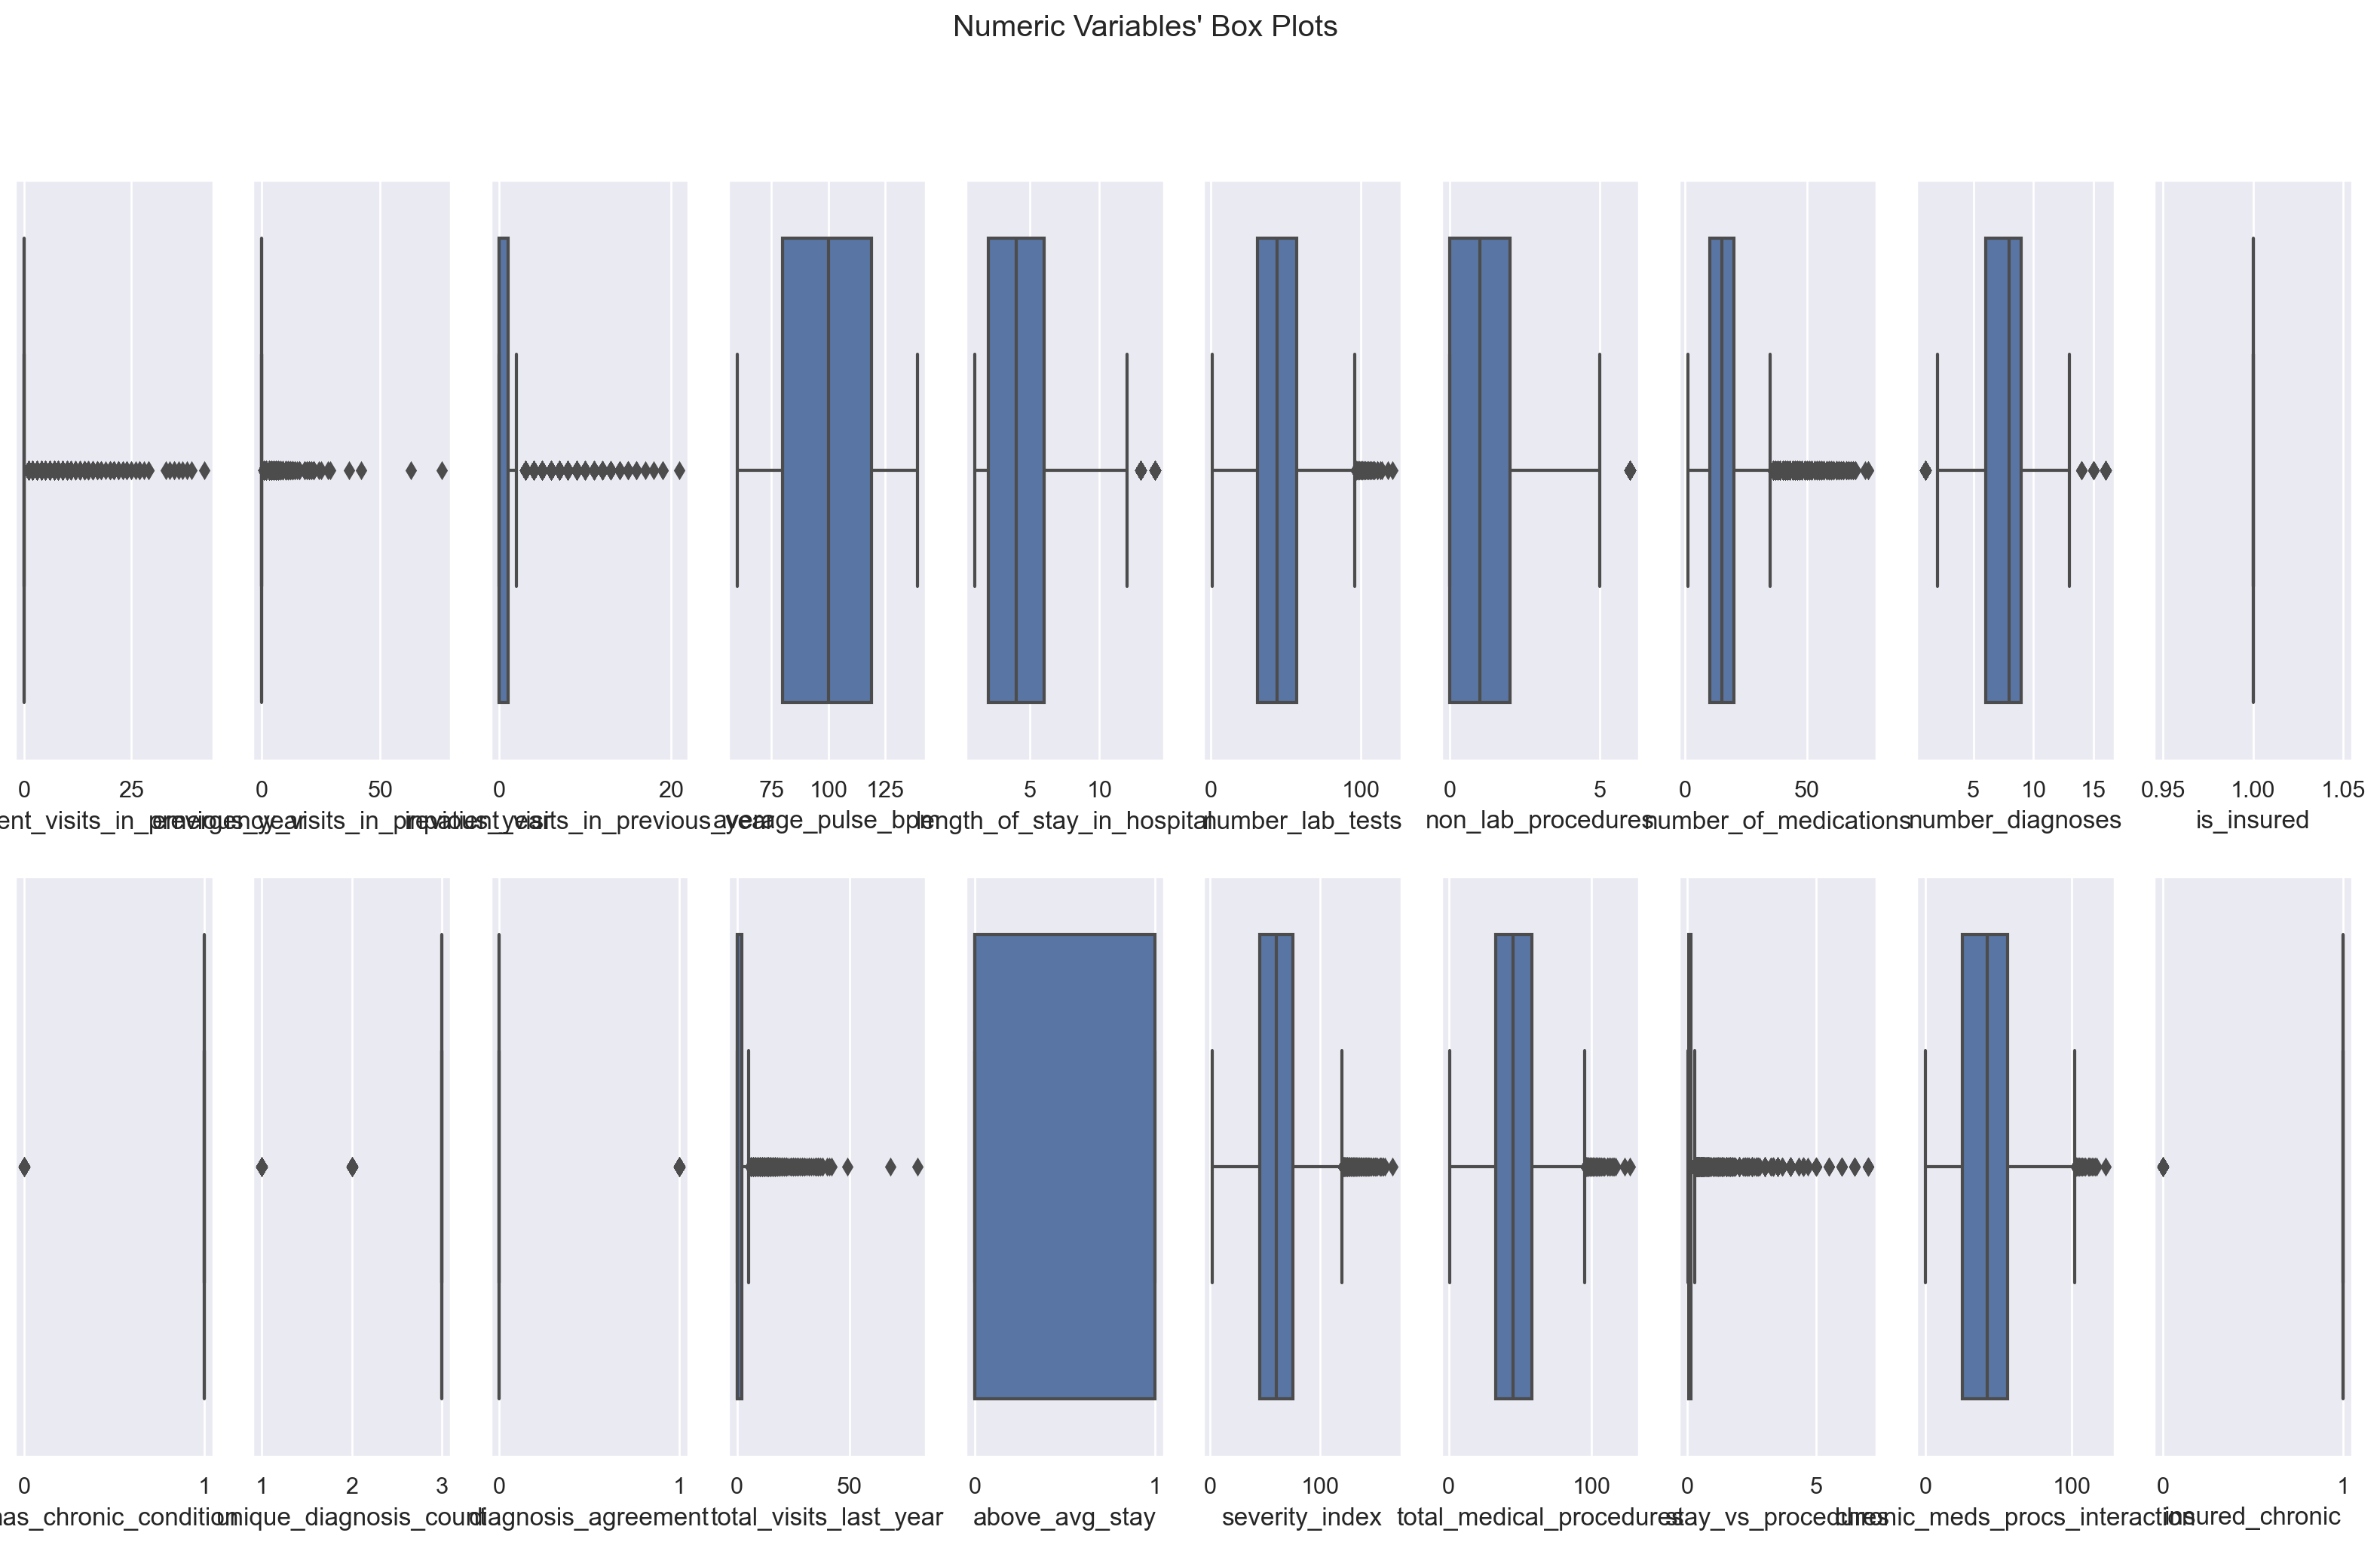

In [532]:
sns.set()

fig, axes = plt.subplots(2, math.ceil(len(metric_features) / 2), figsize=(20, 11))

for ax, feat in zip(axes.flatten(), metric_features): 
    sns.boxplot(data=init_train_copy, x=feat, ax=ax)

title = "Numeric Variables' Box Plots"
plt.suptitle(title)
plt.show()


In [ ]:
metric_features

In [533]:
q25 = init_train_copy[metric_features].quantile(.25)
q75 = init_train_copy[metric_features].quantile(.75)
iqr = (q75 - q25)


upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr


filters = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters.append(init_train_copy[metric].between(llim, ulim, inclusive=True))


filters = pd.Series(np.all(filters, 0), index=init_train_copy.index)
df_1 = init_train_copy[filters]
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / init_train_copy.shape[0], 4))

Percentage of data kept after removing outliers: 0.5164


- **Tons of rows removed because of some sparse data, lets remove the most sparse columns and analyze them personally since they have tons of outliers (as we can see in the box plots)**

In [534]:
outlier_metric_features = [feature for feature in metric_features if feature not in ['outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'total_visits_last_year', 'stay_vs_procedures']]

In [535]:
q25 = init_train_copy[outlier_metric_features].quantile(.25)
q75 = init_train_copy[outlier_metric_features].quantile(.75)
iqr = (q75 - q25)


upper_lim = q75 + 2 * iqr
lower_lim = q25 - 2 * iqr


filters = []
for metric in outlier_metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters.append(init_train_copy[metric].between(llim, ulim, inclusive=True))


filters = pd.Series(np.all(filters, 0), index=init_train_copy.index)
df_2 = init_train_copy[filters]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / init_train_copy.shape[0], 4))

Percentage of data kept after removing outliers: 0.8465


<hr>
<a class="anchor" id="manualiqr">

### 9.3.3. Filters 3 - Manual & IQR
    
</a>

- We keep  IQR for now. We can look into other filters later

In [536]:
init_train_copy = df_2

In [537]:
init_train_copy.shape

(60300, 38)

<hr>
<a class="anchor" id="outlier">
    
# 10. Variables' Values - Proportion
    
</a>

In [ ]:
# we droped the unecessary columns
init_train_weights = init_train_copy.copy()
init_train_weights=init_train_weights.drop(columns={"medication", "primary_diagnosis", "secondary_diagnosis", "additional_diagnosis"})
init_train_weights.columns

In [ ]:
 def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.xticks(rotation=45)
    plt.ylabel("$Frequency$")

   
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                         np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.xticks(rotation=45)
    plt.ylabel("$p$")

    plt.show()  
    
for i in range(len(init_train_weights.columns)):
     bar_charts_categorical(df=init_train_weights,target="readmitted_binary",feature=init_train_weights.columns[i])

<hr>
<a class="anchor" id="outlier">
    
# 11. Mapping Categorical Variables into Numeric
    
</a>

In [ ]:
init_train_copy.head()

In [ ]:
init_train_copy["race"].unique()

In [ ]:
init_train_copy["gender"].unique()

In [ ]:
init_train_copy["age"].unique()

In [ ]:
init_train_copy["payer_code"].unique()

In [ ]:
init_train_copy["admission_type"].unique()

In [ ]:
init_train_copy["medical_specialty"].unique()

In [ ]:
init_train_copy["discharge_disposition"].unique()

In [ ]:
init_train_copy["admission_source"].unique()

In [ ]:
init_train_copy["glucose_test_result"].unique()

In [ ]:
init_train_copy["a1c_test_result"].unique()

In [ ]:
init_train_copy["change_in_meds_during_hospitalization"].unique()

In [538]:
def encode_column(column):
    le = LabelEncoder()
    init_train_copy[column] = le.fit_transform(init_train_copy[column])
    return le.classes_  # Returns the classes for reference
# Encode each column
encoded_race = encode_column('race')
encoded_gender = encode_column('gender')
encoded_age = encode_column('age')
encoded_payer_code = encode_column('payer_code')
encoded_admission_type = encode_column('admission_type')
encoded_admission_type = encode_column('medical_specialty')
encoded_medical_specialty = encode_column('discharge_disposition')
encoded_medical_specialty = encode_column('admission_source')
encoded_medical_specialty = encode_column('glucose_test_result')
encoded_medical_specialty = encode_column('a1c_test_result')
encoded_medical_specialty = encode_column('change_in_meds_during_hospitalization')
encoded_medical_specialty = encode_column('prescribed_diabetes_meds')
encoded_medical_specialty = encode_column('high_hospital_engagement')
encoded_medical_specialty = encode_column('medication')
encoded_medical_specialty = encode_column('primary_diagnosis')
encoded_medical_specialty = encode_column('secondary_diagnosis')
encoded_medical_specialty = encode_column('additional_diagnosis')


init_train_copy.head()

race  gender  age  payer_code  \
encounter_id                                  
533253           2       0    7           7   
426224           0       1    5           7   
634063           2       0    6           7   
890610           0       1    6           7   
654194           2       0    7           6   

              outpatient_visits_in_previous_year  \
encounter_id                                       
533253                                         0   
426224                                         0   
634063                                         0   
890610                                         0   
654194                                         1   

              emergency_visits_in_previous_year  \
encounter_id                                      
533253                                        0   
426224                                        0   
634063                                        0   
890610                                        0   
654194                                        0   

              inpatient_visits_in_previous_year  admission_type  \
encounter_id                                                      
533253                                        2               1   
426224                                        0               1   
634063                                        1               1   
890610                                        1               1   
654194                                        0               0   

              medical_specialty  average_pulse_bpm  discharge_disposition  \
encounter_id                                                                
533253                       10                127                      1   
426224                       17                128                      4   
634063                       10                 94                      1   
890610                       17                 81                      1   
654194                       17                126                     11   

              admission_source  length_of_stay_in_hospital  number_lab_tests  \
encounter_id                                                                   
533253                       1                           2                48   
426224                      12                          14                71   
634063                       1                           6                60   
890610                       9                           6                48   
654194                       5                           6                47   

              non_lab_procedures  number_of_medications  primary_diagnosis  \
encounter_id                                                                 
533253                         0                     20                328   
426224                         0                     25                223   
634063                         1                     22                345   
890610                         2                      9                368   
654194                         1                     15                472   

              secondary_diagnosis  additional_diagnosis  number_diagnoses  \
encounter_id                                                                
533253                        118                   288                 8   
426224                        476                    24                 9   
634063                         10                    78                 6   
890610                        338                   278                 5   
654194                        370                   254                 9   

              glucose_test_result  a1c_test_result  \
encounter_id                                         
533253                          2                1   
426224                          2                1   
634063                          2                1   
890610                          2

<hr>
<a class="anchor" id="outlier">
    
# 12. Correlation check
    
</a>

In [ ]:
# Compute the correlation matrix
correlation_matrix = init_train_copy.corr()

plt.figure(figsize=(20,14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation heatmap')
plt.show()

<hr>
<a class="anchor" id="outlier">
    
# 13. Feature Selection
    
</a>

In [539]:
# Also dropping medication, primary_diagnosis, secondary_diagnosis and additional_diagnosis since they are not numeric
#init_train_copy.drop(columns=(['medication', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis']), inplace=True)
#init_test_copy.drop(columns=(['medication', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis']), inplace=True)

# Assuming you've already preprocessed your data
data = init_train_copy.drop('readmitted_binary', axis=1)  # replace 'target' with your target column
target = init_train_copy['readmitted_binary']

<hr>
<a class="anchor" id="manual">

### 13.1 Recursive Feature Elimination - RFE
</a>

In [541]:
model = LogisticRegression()

rfe = RFE(estimator = model)

X_rfe = rfe.fit_transform(X = data, y = target) 

model.fit(X = X_rfe,y = target)

LogisticRegression()

In [542]:
rfe.support_

array([False, False,  True, False,  True,  True,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True,  True,  True,  True, False, False,  True,  True,
        True, False,  True,  True,  True, False,  True, False,  True,
        True])

In [543]:
rfe.ranking_

array([ 8,  3,  1,  9,  1,  1,  1, 10, 13, 14,  4, 18,  5, 12,  1,  7, 16,
       17, 19,  1,  1,  1,  1, 11, 15,  1,  1,  1, 20,  1,  1,  1,  6,  1,
        2,  1,  1])

In [544]:
data.head()

race  gender  age  payer_code  \
encounter_id                                  
533253           2       0    7           7   
426224           0       1    5           7   
634063           2       0    6           7   
890610           0       1    6           7   
654194           2       0    7           6   

              outpatient_visits_in_previous_year  \
encounter_id                                       
533253                                         0   
426224                                         0   
634063                                         0   
890610                                         0   
654194                                         1   

              emergency_visits_in_previous_year  \
encounter_id                                      
533253                                        0   
426224                                        0   
634063                                        0   
890610                                        0   
654194                                        0   

              inpatient_visits_in_previous_year  admission_type  \
encounter_id                                                      
533253                                        2               1   
426224                                        0               1   
634063                                        1               1   
890610                                        1               1   
654194                                        0               0   

              medical_specialty  average_pulse_bpm  discharge_disposition  \
encounter_id                                                                
533253                       10                127                      1   
426224                       17                128                      4   
634063                       10                 94                      1   
890610                       17                 81                      1   
654194                       17                126                     11   

              admission_source  length_of_stay_in_hospital  number_lab_tests  \
encounter_id                                                                   
533253                       1                           2                48   
426224                      12                          14                71   
634063                       1                           6                60   
890610                       9                           6                48   
654194                       5                           6                47   

              non_lab_procedures  number_of_medications  primary_diagnosis  \
encounter_id                                                                 
533253                         0                     20                328   
426224                         0                     25                223   
634063                         1                     22                345   
890610                         2                      9                368   
654194                         1                     15                472   

              secondary_diagnosis  additional_diagnosis  number_diagnoses  \
encounter_id                                                                
533253                        118                   288                 8   
426224                        476                    24                 9   
634063                         10                    78                 6   
890610                        338                   278                 5   
654194                        370                   254                 9   

              glucose_test_result  a1c_test_result  \
encounter_id                                         
533253                          2                1   
426224                          2                1   
634063                          2                1   
890610                          2

In [545]:
selected_columns = data.columns[selected_features[selected_features==True].index]
selected_columns

Index(['age', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'length_of_stay_in_hospital',
       'non_lab_procedures', 'primary_diagnosis', 'secondary_diagnosis',
       'number_diagnoses', 'glucose_test_result', 'a1c_test_result',
       'prescribed_diabetes_meds', 'medication', 'unique_diagnosis_count'],
      dtype='object')

In [546]:
nof_list = np.arange(1, len(data.columns))
high_score = 0
nof = 0
score_list = []
optimal_columns = None  # Variable to store the column names of the optimal features

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=0)

    model = LogisticRegression()
    rfe = RFE(model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    
    if score > high_score:
        high_score = score
        nof = nof_list[n]
        optimal_columns = data.columns[rfe.support_]

print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))
print("Selected features:")
print(optimal_columns)

Optimum number of features: 10
Score with 10 features: 0.888060
Selected features:
Index(['inpatient_visits_in_previous_year', 'number_diagnoses',
       'a1c_test_result', 'prescribed_diabetes_meds', 'is_insured',
       'has_chronic_condition', 'unique_diagnosis_count', 'above_avg_stay',
       'high_hospital_engagement', 'insured_chronic'],
      dtype='object')


<hr>
<a class="anchor" id="outlier">
    
# 14. Models
    
</a>

<hr>
<a class="anchor" id="manual">

### 14.1 LogisticRegression
</a>

In [548]:
data2 = data.copy()
data2.columns

Index(['race', 'gender', 'age', 'payer_code',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'is_insured', 'has_chronic_condition',
       'unique_diagnosis_count', 'diagnosis_agreement',
       'total_visits_last_year', 'above_avg_stay', 'severity_index',
       'total_medical_procedures', 'high_hospital_engagement',
       'stay_vs_procedures', 'chronic_meds_procs_interaction',
       'insured_chronic'],
      dtype='object')

**According to RFC**

In [549]:
dataRFC = data2[['average_pulse_bpm', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis', 'stay_vs_procedures', 'severity_index', 'number_of_medications', 'number_lab_tests']]

**According to RFE**

In [550]:
dataRFE = data2[['age', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'length_of_stay_in_hospital',
       'non_lab_procedures', 'primary_diagnosis', 'secondary_diagnosis',
       'number_diagnoses', 'glucose_test_result', 'a1c_test_result',
       'prescribed_diabetes_meds', 'medication', 'unique_diagnosis_count']]

**According to RFE with limit features**

In [551]:
dataRFEwLimit = data2[['inpatient_visits_in_previous_year', 'number_diagnoses',
       'a1c_test_result', 'prescribed_diabetes_meds', 'is_insured',
       'has_chronic_condition', 'unique_diagnosis_count', 'above_avg_stay',
       'high_hospital_engagement', 'insured_chronic']]

# Going forward with the model

In [600]:
X_train, X_test, y_train, y_test = train_test_split(dataRFEwLimit,target, test_size=0.2, random_state=5, stratify=target)

In [601]:
log_model = LogisticRegression()

In [602]:
log_model.fit(X_train, y_train)

LogisticRegression()

In [603]:
y_pred = log_model.predict(X_test)
y_pred

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [604]:
pred_prob = log_model.predict_proba(X_test)
pred_prob

array([[0.90359478, 0.09640522],
       [0.92110693, 0.07889307],
       [0.86404694, 0.13595306],
       ...,
       [0.90486929, 0.09513071],
       [0.89008275, 0.10991725],
       [0.92731035, 0.07268965]])

In [605]:
log_model.coef_

array([[ 0.25609098,  0.05871014, -0.54799854,  0.16095204, -0.17474686,
        -0.17474686, -0.52424057,  0.14623403,  0.13241222, -0.17474686]])

In [606]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[10669,    19],
       [ 1353,    19]], dtype=int64)

TP | FP <br>
FN | TN

In [607]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8862354892205638

<hr>
<a class="anchor" id="manual">

### 14.2 RandomForestClassifier
</a>

In [595]:
X_train, X_test, y_train, y_test = train_test_split(dataRFEwLimit,target, test_size=0.2, random_state=5, stratify=target)

In [596]:
rf_model = RandomForestClassifier()

In [597]:
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [598]:
y_pred_rf = rf_model.predict(X_test)

In [599]:
# Compute the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

# Compute the accuracy (optional)
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy:.2f}")

[[10667    21]
 [ 1350    22]]
Accuracy: 0.89


<hr>
<a class="anchor" id="manual">

### 14.3 GradientBoostingClassifier
</a>

In [594]:
X_train, X_test, y_train, y_test = train_test_split(dataRFE,target, test_size=0.2, random_state=5, stratify=target)

gb_model = GradientBoostingClassifier(random_state=5)

gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

# Compute the confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
print(cm_gb)

# Compute the accuracy (optional)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy: {accuracy_gb:.2f}")

[[10672    16]
 [ 1355    17]]
Accuracy: 0.89


<hr>
<a class="anchor" id="manual">

### 14.4 SVC
</a>

In [590]:
X_train, X_test, y_train, y_test = train_test_split(dataRFE,target, test_size=0.2, random_state=5, stratify=target)

gb_model = SVC(random_state=5)

gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

# Compute the confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
print(cm_gb)

# Compute the accuracy (optional)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy: {accuracy_gb:.2f}")

[[10688     0]
 [ 1372     0]]
Accuracy: 0.89
